In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import print_function, division

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [3]:
 # Directory with our gorillas_testing_data_2 for training
train_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing_data_2') 

# Directory with our Gorillas_Validation for validation
valid_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Validation')

# Directory with our Gorillas_Testing for testing
test_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1/Gorillas_Testing')

In [4]:
# Make transforms and use data loaders
# make these variables for future use
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'Gorillas_Testing_data_2': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'Gorillas_Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'Gorillas_Testing':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]) 
}

In [5]:
# set the directory for the data
data_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection1') 

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
  chosen_transforms[x])
                  for x in ['Gorillas_Testing_data_2', 'Gorillas_Validation', 'Gorillas_Testing']}

In [6]:
# Make iterables with the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4,
  shuffle=True, num_workers=2)
              for x in ['Gorillas_Testing_data_2', 'Gorillas_Validation','Gorillas_Testing' ]}

In [7]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['Gorillas_Testing_data_2', 'Gorillas_Validation','Gorillas_Testing' ]}
class_names = chosen_datasets['Gorillas_Testing_data_2'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
dataset_sizes

{'Gorillas_Testing': 48,
 'Gorillas_Testing_data_2': 187,
 'Gorillas_Validation': 76}

imshow for tensor: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

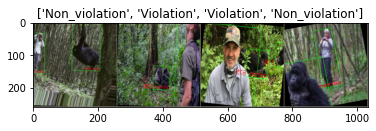

In [10]:
# visualiza some training data to get a sense of data augmentations
inputs, classes = next(iter(dataloaders["Gorillas_Testing_data_2"]))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
# Setting up the model
# load in pretrained and reset final fully connected

res_mod = models.resnet50(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

A general function to train a model, this function will illustrate:
- scheduling the learning rate
- saving the best model


parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Gorillas_Testing_data_2', 'Gorillas_Validation']:
            if phase == 'Gorillas_Testing_data_2':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'Gorillas_Testing_data_2'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Gorillas_Testing_data_2':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            if phase == 'Gorillas_Testing_data_2':
                scheduler.step()

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            # collect accuracy for future use
            if phase == 'Gorillas_Testing_data_2':
              train_acc.append(epoch_acc)
            else:
              val_acc.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'Gorillas_Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Gorillas_Validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/24
----------
Iterating through data...
Gorillas_Testing_data_2 Loss: 0.5475 Acc: 0.7219
Iterating through data...
Gorillas_Validation Loss: 0.1473 Acc: 0.9474

Epoch 1/24
----------
Iterating through data...
Gorillas_Testing_data_2 Loss: 0.2868 Acc: 0.8610
Iterating through data...
Gorillas_Validation Loss: 0.1544 Acc: 0.9474

Epoch 2/24
----------
Iterating through data...
Gorillas_Testing_data_2 Loss: 0.5100 Acc: 0.8128
Iterating through data...
Gorillas_Validation Loss: 0.0749 Acc: 1.0000

Epoch 3/24
----------
Iterating through data...
Gorillas_Testing_data_2 Loss: 0.2539 Acc: 0.9144
Iterating through data...
Gorillas_Validation Loss: 0.1142 Acc: 0.9474

Epoch 4/24
----------
Iterating through data...
Gorillas_Testing_data_2 Loss: 0.5471 Acc: 0.7968
Iterating through data...
Gorillas_Validation Loss: 0.1553 Acc: 0.9211

Epoch 5/24
----------
Iterating through data...
Gorillas_Testing_data_2 Loss: 0.5708 Acc: 0.8556
Iterating through data...
Gorillas_Validation Loss: 0.3404

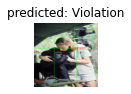

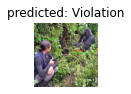

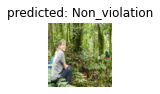

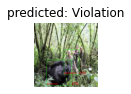

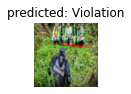

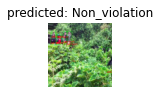

In [15]:
train_acc=[]
val_acc=[]
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
visualize_model(base_model)
plt.show()

In [16]:
tacc = torch.stack(train_acc)
tacc = tacc.cpu().detach().numpy()
vacc = torch.stack(val_acc)
vacc = vacc.cpu().detach().numpy()

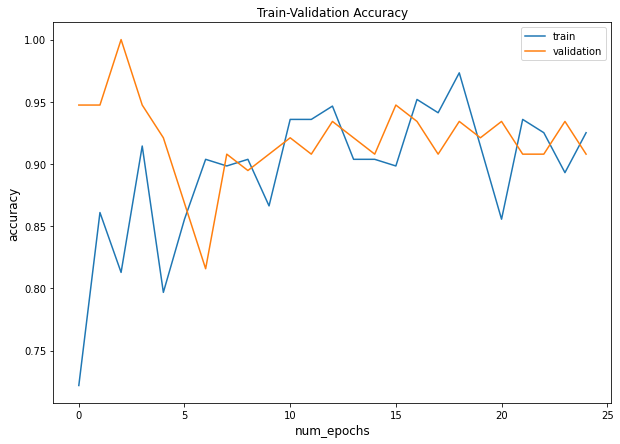

In [17]:
# accuracy plot
fig = plt.figure(figsize=(10,7))
plt.title("Train-Validation Accuracy")
plt.plot(tacc, label='train')
plt.plot(vacc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

use the test dataset to see the performance

In [18]:
predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device = 'cpu')

with torch.no_grad():
  for inputs, classes in dataloaders['Gorillas_Testing']:
    inputs = inputs.to(device)
    classes = classes.to(device)
    outputs = base_model(inputs)
    _, preds = torch.max(outputs, 1)

    predlist=torch.cat([predlist, preds.view(-1).cpu()])
    lbllist=torch.cat([lbllist, classes.view(-1).cpu()])

  preds = predlist.numpy()
  labels = lbllist.numpy()

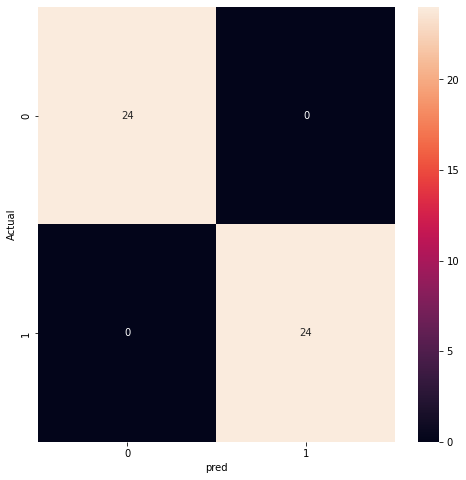

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [20]:
cm=confusion_matrix(labels,preds)
print(cm)

[[24  0]
 [ 0 24]]


In [21]:
from sklearn.metrics import classification_report
matrix = classification_report(labels,preds,target_names=class_names)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       1.00      1.00      1.00        24
    Violation       1.00      1.00      1.00        24

     accuracy                           1.00        48
    macro avg       1.00      1.00      1.00        48
 weighted avg       1.00      1.00      1.00        48

